In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from soda.dataio.conversion.dem import DEM, blendDEMs
from soda.utils.fkriging import kriging, find_tri_nearest
from soda.utils.interpXYZ import interpXYZ
from scipy.ndimage import filters

from scipy.spatial import Delaunay
from matplotlib import tri as mpltri
from scipy import spatial
import pdb

import copy

In [27]:
basedir = '/home/suntans/Share/ScottReef/DATA/BATHYMETRY/'

#basefile = '%s/dem_GA2009_NWS.nc'%basedir
basefile = '%s/dem_GEBCO_NWS.nc'%basedir

#infile = '%s/GA_WEL_MultiBeam_NWSBrowse_DEM.nc'%basedir #
infile = '%s/NGDC_GA_WEL_MultiBeam_NWSBrowse_DEM.nc'%basedir
# Bounds for testing only (Rowley Shoals)
x0 = 118.5
x1 = 120.5
y0 = -18.
y1 = -16.8

# Scott Reef
x0 = 121.5 
x1 = 124.5
y0 = -14.5
y1 = -12.0

bufferdist = 6.5/100.
zcutoff = -600.

clip = True

In [28]:
dem1 = DEM(infile, W=10, maxdist=bufferdist)

dem_bg = DEM(basefile, W=1, maxdist=bufferdist)

In [29]:
if clip:
    dem1.clip(x0,x1,y0,y1)
    dem_bg.clip(x0,x1,y0,y1)

dem1.Z[dem1.Z==0.] = np.nan


<IPython.core.display.Javascript object>


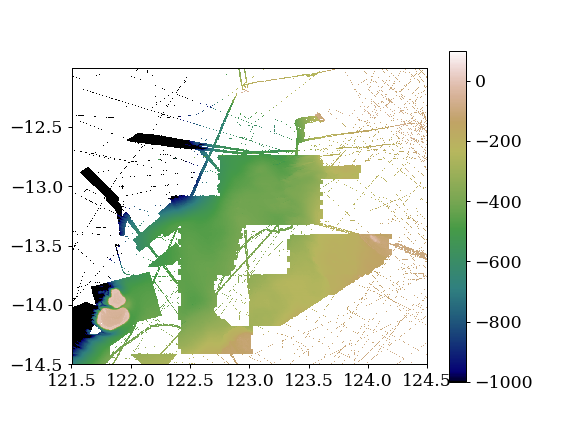

In [30]:
plt.figure()

dem1.plot(shading=False, vmin=-1000, vmax=100)

In [6]:
# Create an interpolation object
xyin = dem1.nonnanxy()
xyout = dem1.nanxy()
idx = np.isnan(dem1.Z)
Zin = dem1.Z[~idx]


dem2 = copy.deepcopy(dem1)

#dem2.Z[idx] = Zout
#F = interpXYZ(xyin, xyout, method='curvmin')

#Zout = F(Zin)

In [31]:
##  downsampling onto random points instead
sampledist = 0.025
sz =int(dem1.ny*dem1.nx//(sampledist/0.0025)**2)
print sz
xsample = np.random.uniform(low=x0,high=x1, size=(sz,))
ysample = np.random.uniform(low=y0,high=y1, size=(sz,))

zsample = dem_bg.interp(xsample, ysample)

plt.figure()
dem1.plot(vmin=-500, vmax=100, shading=False)
plt.plot(xsample, ysample,'m.',ms=0.5)

11978


<IPython.core.display.Javascript object>

In [32]:
# Create a buffer zone
print 'Finding the buffer zone...'
#idx = ~np.isnan(dem1.Z)
XY_wel = np.column_stack([dem1.X[~idx], dem1.Y[~idx]])

# compute the spatial tree
kd = spatial.cKDTree(XY_wel)  

# Distance of the GA data to WEL points
print 'spatial querying...'
XY_ga = np.column_stack([xsample, ysample])

dist, ind = kd.query(XY_ga)

# These are the points to blank out
#idx_ga = operator.or_(dist < bufferdist, dem_bg.Z.ravel() > zcutoff )
idx_buffer = dist > 1.2*sampledist # Distance only cutoff

#idx_buffer = ((dist > bufferdist) & (zsample>zcutoff))  | ((dist > 3*bufferdist) & (zsample < zcutoff))

#idx_buffer = np.reshape(idx_buffer,(demout.ny,demout.nx))
idx2 = idx_buffer


Finding the buffer zone...
spatial querying...


<IPython.core.display.Javascript object>


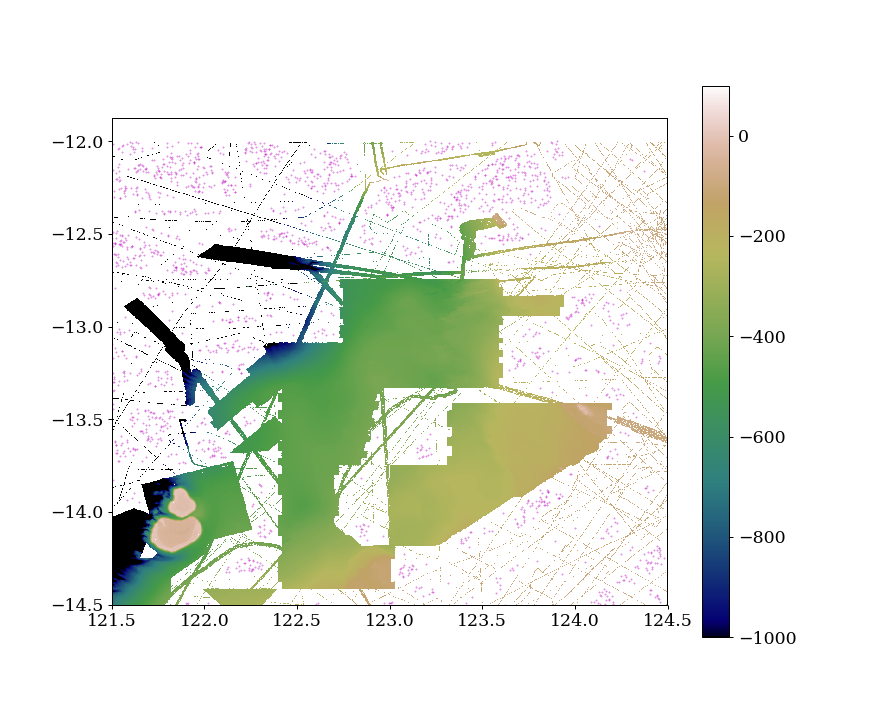

In [33]:
plt.figure(figsize=(10,8))
dem1.plot(vmin=-1000, vmax=100, shading=False)
plt.plot(xsample[idx2], ysample[idx2],'m.',ms=0.5)

In [10]:
xyin2 = np.column_stack([xsample[idx2],ysample[idx2]])
xyin2 = np.vstack([xyin, xyin2])

Zin2 = np.hstack([Zin, zsample[idx2]])

In [34]:
# Try out the new kriging method
Fk = kriging(xyin2, xyout,
        #distance_func=find_tri_nearest, NNear=7,
        NNear=17, 
        vrange=0.02, sill=0.9, nugget=0.3,\
        #anisofac=anisofac[:,np.newaxis],
    )
Zout = Fk(Zin2)

dem2.Z[idx] = Zout

775369 interpolation points.


<IPython.core.display.Javascript object>


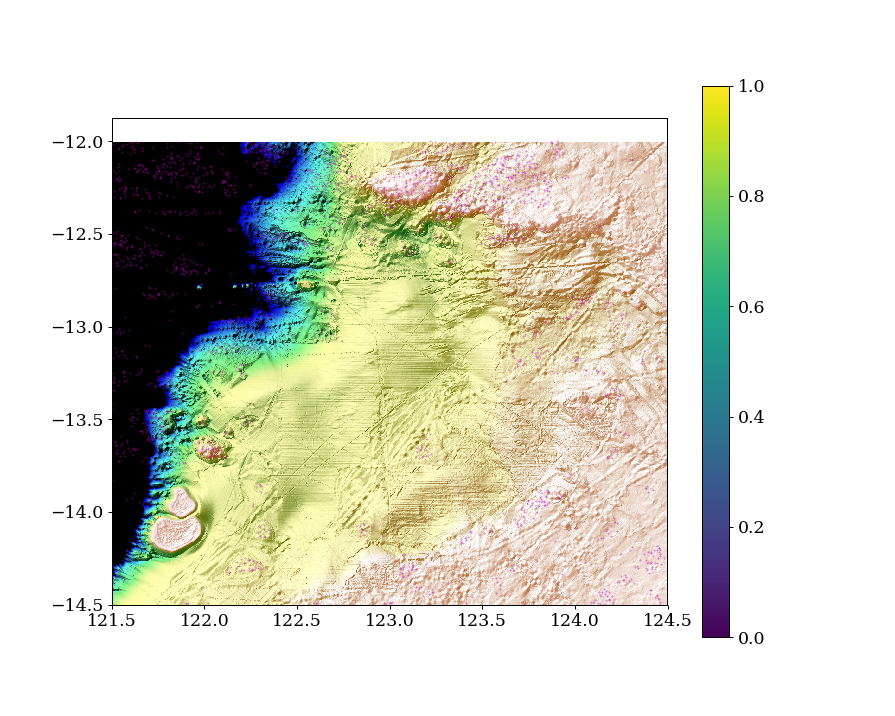

In [35]:
plt.figure(figsize=(10,8))
dem2.plot(vmin=-1500, vmax=100, shading=True)
plt.plot(xsample[idx2], ysample[idx2],'m.',ms=0.5)

In [14]:
# Smooth the filled regions

# Re-fill in the background dem with the filtered points
dem_f = copy.deepcopy(dem2)
dem_f.Z[np.isnan(dem_f.Z)]=0.

print 'Filtering the buffer zone...'
niter = 1
for ii in range(niter):
    #dem_f.Z = filters.gaussian_filter(dem_f.Z, 4)
    #dem_f.Z = filters.generic_filter(dem_f.Z, np.mean, size=(3,3))
    dem_f.Z = filters.uniform_filter(dem_f.Z, size=(10,10 ))
    #dem_f.Z = filters.laplace(dem_f.Z)
    # Re-fill the non buffer  region
    dem_f.Z[~idx] = dem2.Z[~idx]
    

# Filter everything
dem_f.Z = filters.uniform_filter(dem_f.Z, size=(5,5 ))

#dem_f.Z[idx] = dem1.Z[idx]

Filtering the buffer zone...


<IPython.core.display.Javascript object>


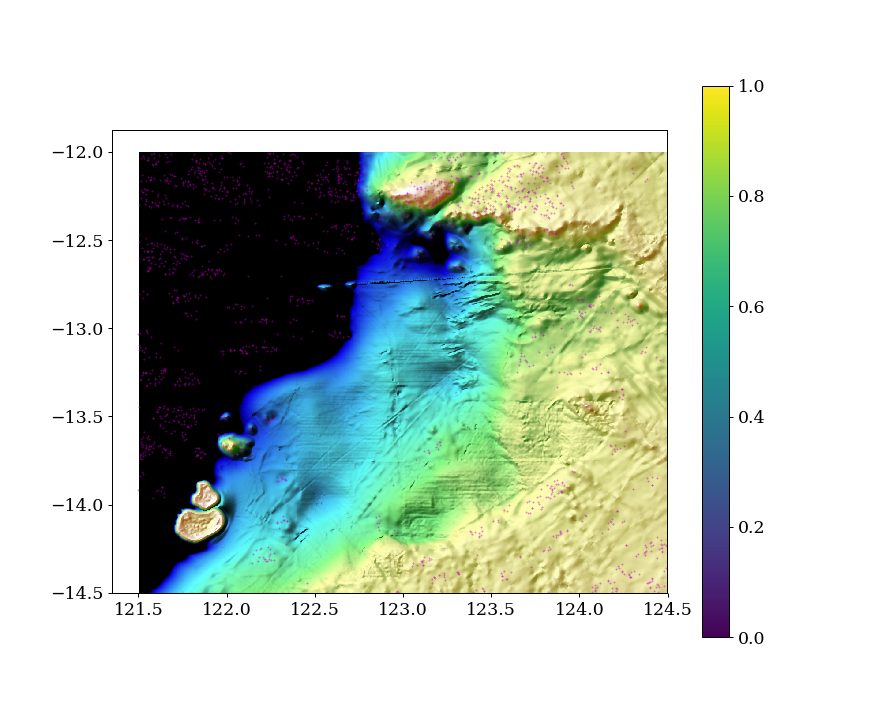

In [17]:
plt.figure(figsize=(10,8))
dem_f.plot(vmin=-600, vmax=100, shading=True)
plt.plot(xsample[idx2], ysample[idx2],'m.',ms=0.5)

# Test anisotropic interpolation

0.0


/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


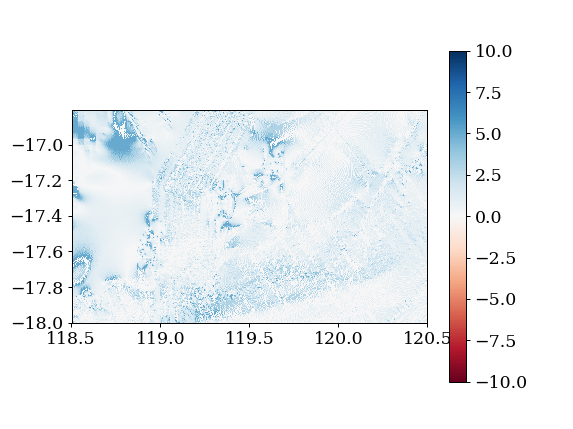

In [7]:

# Compute an anisotropy from the background grid
dh_x, dh_y = np.gradient(dem_bg.Z)

anisofac = dh_x/dh_y
print np.abs(dh_y).min()
anisofac[np.abs(dh_y)<1e-3] = 0.

#anisofac = dh_y/dh_x
#print np.abs(dh_x).min()
#anisofac[np.abs(dh_x)<1e-3] = 0.

anisofac = np.abs(anisofac)
anisofac[anisofac>5] =5.

dem_aniso = copy.deepcopy(dem_bg)
dem_aniso.Z = anisofac

plt.figure()
dem_aniso.plot(shading=False, vmin=-10, vmax=10, cmap='RdBu')
#dem_aniso.plot(shading=False)
#plt.plot(xyin[:,0],xyin[:,1],'m.',ms=0.2)

anisofac = dem_aniso.interp(xyout[:,0],xyout[:,1])


In [15]:
#F = interpXYZ(xyin, xyout, method='kriging', NNear=8, vrange=1e-4, sill=0.9, nugget=0.5)

# Try out the new kriging method
Fk = kriging(xyin, xyout,
        distance_func=find_tri_nearest, NNear=7,
        #NNear=17, 
        vrange=0.1, sill=0.7, nugget=0.3,\
        anisofac=anisofac[:,np.newaxis],
    )
Zout = Fk(Zin)

dem2.Z[idx] = Zout


0 312760
10000 312760
20000 312760
30000 312760
40000 312760
50000 312760
60000 312760
70000 312760
80000 312760
90000 312760
100000 312760
110000 312760
120000 312760
130000 312760
140000 312760
150000 312760
160000 312760
170000 312760
180000 312760
190000 312760
200000 312760
210000 312760
220000 312760
230000 312760
240000 312760
250000 312760
260000 312760
270000 312760
280000 312760
290000 312760
300000 312760
310000 312760
312760 interpolation points.


<IPython.core.display.Javascript object>


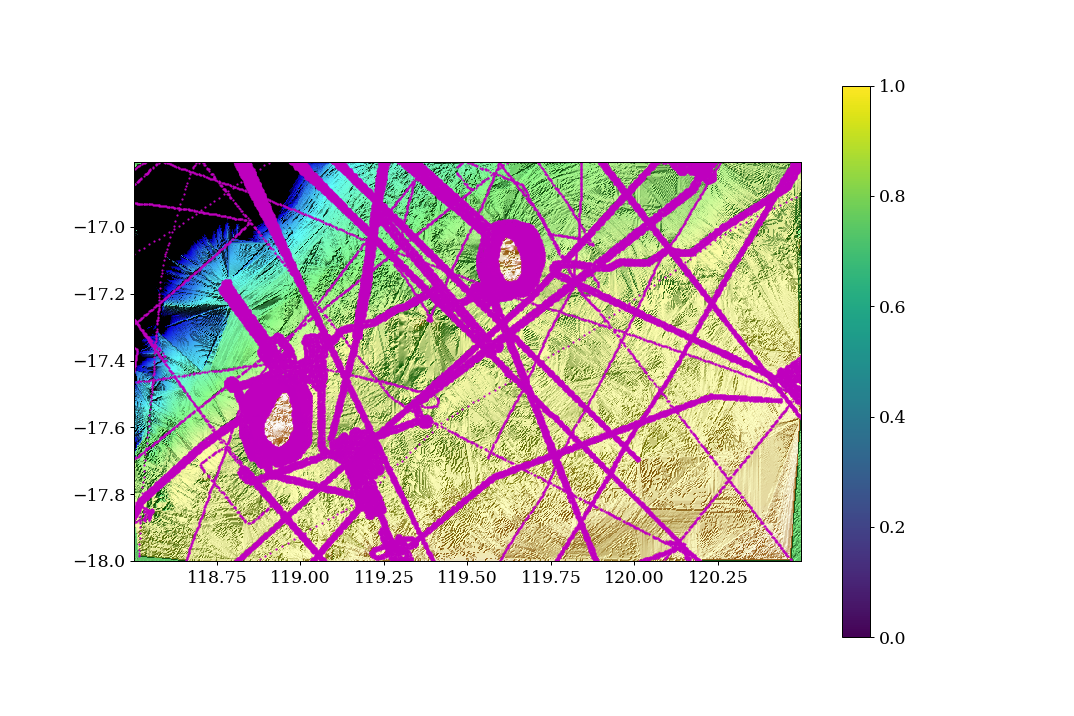

In [20]:
plt.figure(figsize=(12,8))
 
dem2.plot(shading=True, vmin=-1000, vmax=100)
plt.plot(xyin[:,0],xyin[:,1],'m.',ms=1.5)

In [10]:
Fk.W

array([[ 0.54211985,  0.55498849,  0.43089448, ...,  0.93242079,
         0.92639573,  0.9206809 ],
       [ 0.50357711,  0.38085369,  0.42380453, ..., -0.07092041,
        -0.0733156 , -0.07488488],
       [ 0.00972009,  0.38085369, -0.10751904, ...,  0.13608248,
         0.1370974 ,  0.13693312],
       ..., 
       [-0.0659493 , -0.12744997, -0.10883044, ..., -0.05846115,
        -0.0650869 , -0.07060543],
       [ 0.12245971,  0.00651881, -0.16648732, ...,  0.05589891,
         0.06790791,  0.07885132],
       [-0.06715462,  0.00651881, -0.14047641, ..., -0.02456021,
        -0.02583459, -0.02562292]])

In [ ]:


plt.figure()

dem2.plot(shading=True, vmin=-1000, vmax=100)

In [ ]:
F3 = interpXYZ(xyin, xyout, method='idw', NNear=5, p=2)
Zout = F3(Zin)

dem2.Z[idx] = Zout

plt.figure()

dem2.plot(shading=True, vmin=-1000, vmax=100)
plt.plot(xyin[:,0],xyin[:,1],'m.',ms=0.2)

In [ ]:
trid = Delaunay(xyin)
trid.vertex_neighbor_vertices


In [ ]:
plt.figure()
#plt.triplot(xyin[:,0],xyin[:,1], triangles=tri.triangles, linewidth=0.1)
plt.triplot(xyin[:,0],xyin[:,1], triangles=trid.vertices, linewidth=0.1)

In [ ]:
# Find
ll = 75000
nnear = 12
xpt,ypt = xyout[ll,0], xyout[ll,1]

# Find the cell idx
cidx = trid.find_simplex([xpt,ypt])
cidx = [cidx]
nodes = set(trid.simplices[cidx])
flag=True
while flag:
    # Loop through the neighbours
    for cc in cidx:
        neighs = trid.neighbors[cc]
        for ff in neighs:
            if ff == -1:
                break
            newnodes = trid.simplices[ff]
            for nn in newnodes:
                if nn not in nodes and nn != -1:
                    nodes.add(nn)

                    if len(nodes) == nnear:
                        flag=False

        cidx = neighs
        
xnear, ynear = xyin[list(nodes),0], xyin[list(nodes),1]



plt.figure()
##plt.triplot(xyin[:,0],xyin[:,1], triangles=tri.triangles, linewidth=0.1)
plt.triplot(xyin[:,0],xyin[:,1], triangles=trid.vertices, linewidth=0.1)
plt.plot(xpt,ypt,'r*')
plt.plot(xnear, ynear,'yo')


In [ ]:
# Try out the new kriging method
Fk = kriging(xyin, xyout,
        #distance_func=find_tri_nearest,
        NNear=8, vrange=1e-4, sill=0.9, nugget=0.5, anisofac=anisofac[:,np.newaxis])


In [ ]:
Zout = Fk(Zin)

dem2.Z[idx] = Zout

plt.figure()

dem2.plot(shading=True, vmin=-1000, vmax=100)
plt.plot(xyin[:,0],xyin[:,1],'m.',ms=0.2)

In [ ]:
Fk.ind
